# AMEX Default Prediction

## Set up

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pyarrow
from sklearn import preprocessing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing - Supervised
This assumes you have the data from [Radder](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format) saved in a `dataset` folder

In [45]:
# global parameters
SAMPLE = True

# load parquet data
data = pd.read_parquet('dataset/train.parquet')

raw_labels = pd.read_csv('dataset/train_labels.csv')

# use a smaller subset for fast pipeline during testing
if SAMPLE:
    sample = raw_labels['customer_ID'][:10000]
    data = data[data['customer_ID'].isin(sample)]

In [46]:
# preprocessing
from src.data_preprocessing import create_features, custom_processing
from sklearn.model_selection import train_test_split

X, y = create_features(data, raw_labels)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)

# X_train, X_val, y_train, y_val = custom_processing(X_train, X_val, y_train, y_val)


transformed binary features
transformed categorical features
transformed continuous features


## Supervised methods
### Vanilla XG Boost

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from src.evaluation import *

### Evaluation Methods
We want to recreate the evaluation metric from the competition: https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation
For this, first we introduce two terms:

- Normalized Gini Coefficient (G). Here is was calculated from the AUC score using the formula
$$GINI = (2*AUC)-1 $$
- Default rate at 4% (D). This captures a Sensitivity/Recall statistic by calculating the portion of defaults in the highest-ranked 4% of predictions.
  
Using **G** and **D** our evaluaton metric **M** is found by:
$$M = 0.5 \cdot(G+D) $$

The best-performing models achieve scores of 0.80 in this metric, and we hope to achieve accuracy close to that. There appears to be some inconsistency with regards to the training and test data provided by AMEX, as the test data is not merely a random sample of the training data. Instead the test data covers not only a separate set of customers, but also a different time period, Initial results show the M score close to 93% in the validation set, but around 70% in the competition. Therefore, validation accuracy is not a true reflection of test accuracy in this setting.

### Model fitting

In [48]:
max_samples_training = -1
xgb = GradientBoostingClassifier()
xgb.fit(X_train[:max_samples_training], y_train[:max_samples_training])
print("finished training")


finished training


In [49]:
pred = xgb.predict_proba(X_val)
print("finished evaluating")

finished evaluating


In [50]:
if SAMPLE:
    evaluate_model(y_val, pred, traditional = True)


Traditional Metrics:
    tp: 406, fp: 100, tn: 1382, fn: 112
     The precision score is  0.8023715415019763
     The recall score is  0.7837837837837838
     The accuracy score is  0.894
     F-Measure:  0.79296875
AUC Score: 0.9545289940026783
GINI Score: 0.9090579880053566
Default rate at 4%: 0.638996138996139
M: 0.7740270635007478


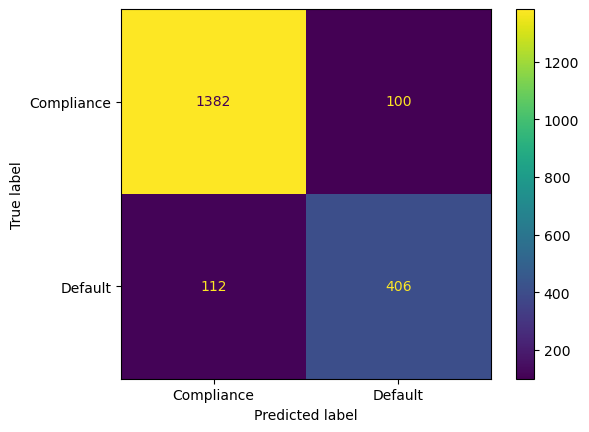

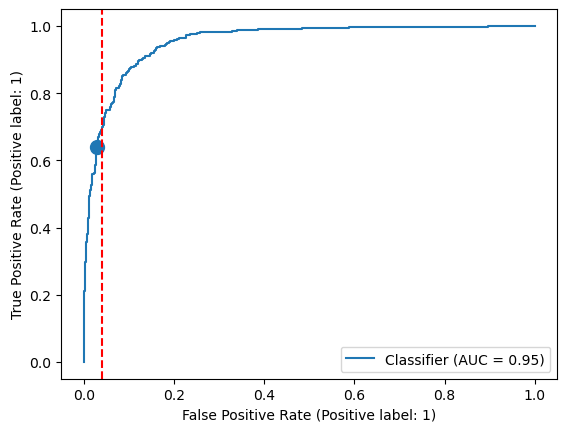

In [51]:
# plots
plot_confusion_matrix(y_val,pred)
plot_GINI(y_val,pred)

### Light GBM
This shows a lot of success in the leaderboards. Code adapted from [Martin's](https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963) notebook

If lightgmb doesn't import, refer to installation instructions on these [docs](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#macos)

In [52]:
import lightgbm as lgb

max_samples_training = -1

features = [col for col in X_train.columns if col not in ['customer_ID']]
params = {
    'objective': 'binary',
    'metric': ["binary_logloss","auc"],
    'boosting': 'dart',
    'seed': 42,
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.20,
    'bagging_freq': 10,
    'bagging_fraction': 0.50,
    'lambda_l2': 2,
    'min_data_in_leaf': 40
    }
train_data = lgb.Dataset(X_train[:max_samples_training], label=y_train[:max_samples_training])
val_data = lgb.Dataset(X_val, label=y_val)



In [53]:
num_round = 100
bst = lgb.train(params = params, train_set = train_data, num_boost_round = num_round, valid_sets=[train_data,val_data], verbose_eval= 500)


/opt/anaconda3/envs/amex/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 2130, number of negative: 5869
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100630
[LightGBM] [Info] Number of data points in the train set: 7999, number of used features: 681
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266283 -> initscore=-1.013562
[LightGBM] [Info] Start training from score -1.013562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [54]:
lgb_preds = bst.predict(X_val)[:,np.newaxis]
pred_lgb = np.concatenate([1-lgb_preds, lgb_preds],axis = 1)
evaluate_model(y_val, pred_lgb, traditional = True)

Traditional Metrics:
    tp: 241, fp: 22, tn: 1460, fn: 277
     The precision score is  0.9163498098859315
     The recall score is  0.46525096525096526
     The accuracy score is  0.8505
     F-Measure:  0.617157490396927
AUC Score: 0.9496688707215023
GINI Score: 0.8993377414430046
Default rate at 4%: 0.6042471042471043
M: 0.7517924228450544


0.7517924228450544

## FeedForward Neural Network

In [64]:
from src.supervised import FeedForwardNN
import tensorflow as tf

net = FeedForwardNN(in_dims = len(X.columns))

s = tf.keras.backend.clear_session()
model=net.create_net()
model.summary()

model = net.compile_net(model)
print(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                46400     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________


In [65]:
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier

batch_size = 64
epochs = 20
init_lr = 0.01

def lr_scheduler(epoch):
    new_lr = init_lr * 0.8 ** epoch
    print("Learning rate:", new_lr)
    return new_lr

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=1,
    initial_epoch=0, 
    validation_data=(X_val, y_val)
)
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


Learning rate: 0.01
Epoch 1/20
125/125 [==============================] - 1s 5ms/step - loss: 4.3998 - auc: 0.7968 - val_loss: 0.4045 - val_auc: 0.9301 - lr: 0.0100
Learning rate: 0.008
Epoch 2/20
125/125 [==============================] - 0s 2ms/step - loss: 0.4717 - auc: 0.9067 - val_loss: 0.4230 - val_auc: 0.9260 - lr: 0.0080
Learning rate: 0.006400000000000001
Epoch 3/20
125/125 [==============================] - 0s 2ms/step - loss: 0.4624 - auc: 0.9022 - val_loss: 0.4253 - val_auc: 0.9205 - lr: 0.0064
Learning rate: 0.005120000000000001
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3148 - auc: 0.9321 - val_loss: 0.2769 - val_auc: 0.9461 - lr: 0.0051
Learning rate: 0.004096000000000001
Epoch 5/20
125/125 [==============================] - 0s 3ms/step - loss: 0.3071 - auc: 0.9326 - val_loss: 0.2643 - val_auc: 0.9492 - lr: 0.0041
Learning rate: 0.0032768000000000007
Epoch 6/20
125/125 [==============================] - 0s 3ms/step - loss: 0.2658 - auc: 0

In [66]:
pred_raw = model.predict(X_val)

pred_nn = np.concatenate([1-pred_raw, pred_raw],axis = 1)
evaluate_model(y_val, pred_nn, traditional = True)

63/63 [==============================] - 0s 1ms/step
Traditional Metrics:
    tp: 405, fp: 91, tn: 1391, fn: 113
     The precision score is  0.8165322580645161
     The recall score is  0.7818532818532818
     The accuracy score is  0.898
     F-Measure:  0.7988165680473371
AUC Score: 0.9537487169066116
GINI Score: 0.9074974338132231
Default rate at 4%: 0.6583011583011583
M: 0.7828992960571908


0.7828992960571908